2025-07-26 17:25:39.927 | DEBUG    | pypso.core:__init__:66 - 初始化PSO算法，使用以下参数：{
    "num_particles": 100,
    "num_dimensions": 3,
    "max_iterations": 10000,
    "inertia_weight_max": 2.0,
    "inertia_weight_min": 0.5,
    "cognitive_coefficient": 0.5,
    "social_coefficient": 0.5,
    "position_bound_min": 0.0,
    "position_bound_max": 100.0,
    "velocity_bound_max": 1.0
}
2025-07-26 17:25:39.927 | DEBUG    | pypso.core:__init__:82 - 定义矩阵大小为：100 x 3
2025-07-26 17:25:39.929 | DEBUG    | pypso.core:__init__:85 - 随机初始化粒子位置：[[67.51462276 84.4458734  30.15386499]
 [55.85768555 56.16125546 67.68780747]
 [88.73341036  8.49006011 63.65348988]
 [80.86888351 84.59141457  8.97579016]
 [46.87555283 83.15108512 99.41772048]
 [16.63559731 87.20197858 75.59428185]
 [56.4381233  82.7533555  87.51907841]
 [38.63972174 28.58822265 49.40469049]
 [54.84308085 82.86425929 65.30643028]
 [89.28729129 66.30652913 73.47698452]
 [87.07294703  9.56728306  5.79931108]
 [53.0442953  41.31307814 79.39219188]

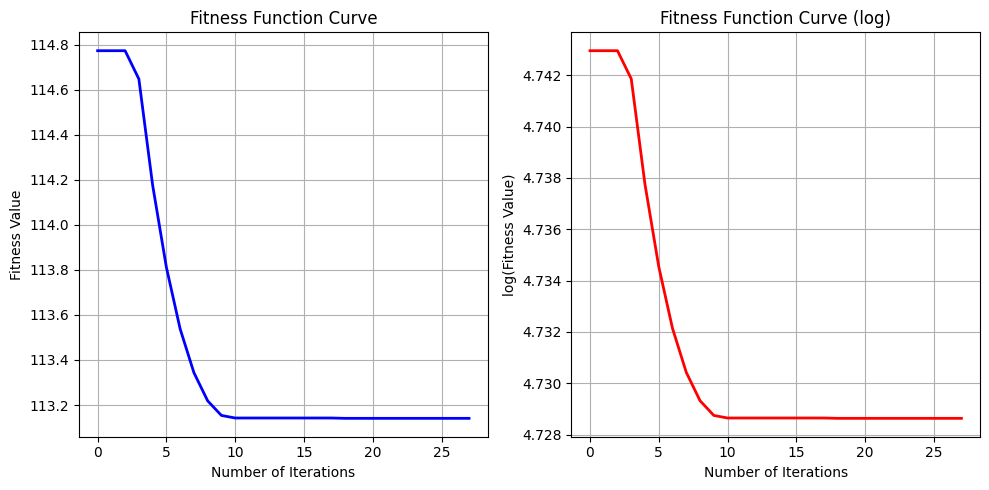

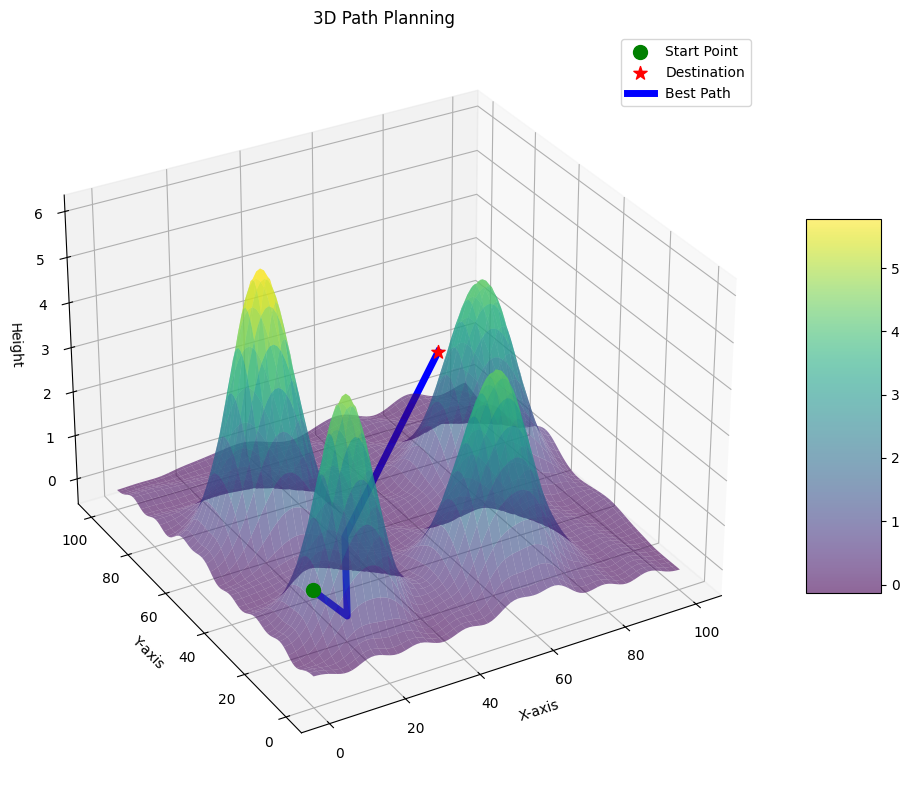

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist

from pypso import plot
from pypso.core import ProblemType, PyPSO, AlgorithmArguments

# 定义山峰的位置和参数
peaks = [
    # center_x, center_y, amplitude, width
    (20, 20, 6, 6),
    (20, 60, 7, 7),
    (60, 20, 5, 8),
    (80, 60, 5, 8),
]


def generate_terrain(x_grid: np.ndarray, y_grid: np.ndarray) -> np.ndarray:
    """
    生成地形图在Z网格的坐标

    Args:
        x_grid (np.ndarray): X平面网格
        y_grid (np.ndarray): Y平面网格
    """
    # 生成基础地形
    z_grid = np.zeros_like(x_grid)

    # 添加山峰
    for (center_x, center_y, amplitude, width) in peaks:
        z_grid += amplitude * np.exp(-((x_grid - center_x) ** 2 + (y_grid - center_y) ** 2) / (2 * width ** 2))

    # 添加一些随机噪声和基础波动，增强山峰的真实性
    z_grid += 0.2 * np.sin(0.5 * np.sqrt(x_grid ** 2 + y_grid ** 2)) + 0.1 * np.random.normal(size=x_grid.shape)

    # 使用高斯滤波，保持山峰独立性的同时也保证平滑性
    z_grid = gaussian_filter(z_grid, sigma=3)

    return z_grid


class PathPlanning3D:

    def __init__(self):
        # 定义路径起点和终点
        self.start_point = (0.0, 0.0, 2.0)
        self.destination = (80.0, 80.0, 2.0)

        # 生成坐标网格
        x = np.linspace(0, 100, 100)
        y = np.linspace(0, 100, 100)
        self.x_grid, self.y_grid = np.meshgrid(x, y)
        self.z_grid = generate_terrain(self.x_grid, self.y_grid)

    def plot_map_with_best_path(self, best_path_points: np.ndarray) -> None:
        """
        绘制地形和最优路径

        Args:
            best_path_points (np.ndarray): 最优路径点坐标数组，形状为 (n, 3)
        """
        # 绘制地形
        figure = plt.figure(figsize=(10, 8))
        ax = figure.add_subplot(111, projection="3d")
        surface = ax.plot_surface(self.x_grid, self.y_grid, self.z_grid, cmap="viridis", alpha=0.6)
        figure.colorbar(surface, shrink=0.5, aspect=5)

        # 标记起点和终点
        start_point_x, start_point_y, start_point_z = self.start_point[0], self.start_point[1], self.start_point[2]
        destination_x, destination_y, destination_z = self.destination[0], self.destination[1], self.destination[2]
        ax.scatter(start_point_x, start_point_y, start_point_z, c='green', s=100, marker='o', label='Start Point')
        ax.scatter(destination_x, destination_y, destination_z, c='red', s=100, marker='*', label='Destination')

        # 绘制路径
        path_points = np.vstack(([self.start_point], best_path_points, [self.destination]))
        path_x, path_y, path_z = path_points[:, 0], path_points[:, 1], path_points[:, 2]
        ax.plot(path_x, path_y, path_z, 'b-', linewidth=5, label='Best Path')

        # 设置坐标轴信息，elev参数控制仰角，azim参数控制方位角
        ax.view_init(elev=30, azim=240)
        ax.set_title("3D Path Planning")
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Height")
        ax.legend()

        plt.tight_layout()
        plt.show()

    def compute_path_cost(self, positions: np.ndarray) -> np.ndarray:
        """
        适应度函数：计算路径成本

        Args:
            positions (np.ndarray): 所有粒子的位置向量

        Returns:
            路径成本大小
        """
        distance_matrix = cdist(positions, np.array([
            self.start_point,
            self.destination,
        ]), metric='euclidean')
        return np.sum(distance_matrix, axis=1)


if __name__ == "__main__":
    path_planning_3d = PathPlanning3D()
    # 初始化PSO优化器
    pso_optimizer = PyPSO(AlgorithmArguments(
        num_particles=100,
        num_dimensions=3,
        max_iterations=10000,
        position_bound_min=0,
        position_bound_max=100,
        velocity_bound_max=1,
        inertia_weight_max=2,
        inertia_weight_min=0.5,
        cognitive_coefficient=0.5,
        social_coefficient=0.5,
        fitness_function=lambda positions: path_planning_3d.compute_path_cost(positions)
    ))
    # 执行算法迭代
    best_solutions, best_fitness_values = pso_optimizer.start_iterating(ProblemType.MINIMIZATION)
    # 绘制适应度曲线
    plot.plot_fitness_curve(best_fitness_values)
    # 绘制最优路径
    path_planning_3d.plot_map_with_best_path(best_solutions)
